In [48]:
import pandas as pd #Import pandas untuk mengolah data
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split 
from nltk.stem import PorterStemmer, WordNetLemmatizer #Import modul stemmer dan lemmatizer
from nltk.corpus import stopwords #Import stopwords dari libary nltk
import re #Import library regular expression
from tqdm import tqdm #import library untuk membuat loading progress (optional)

In [49]:
df_en = pd.read_csv('mbti_1.csv') #Import data
df_en

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...
...,...,...
8670,ISFP,'https://www.youtube.com/watch?v=t8edHB_h908||...
8671,ENFP,'So...if this thread already exists someplace ...
8672,INTP,'So many questions when i do these things. I ...
8673,INFP,'I am very conflicted right now when it comes ...


In [50]:
ps = PorterStemmer() #Mendefinisikan Stemmer
wn = WordNetLemmatizer() #Mendefinisikan Lemmatizer

stpwds_en = list(set(stopwords.words('english'))) #Mendefinisikan stopwords bahasa inggris

'''
Mendefinisikan fungsi untuk case folding
'''
def text_process(teks):
  teks = teks.lower() # Membuat seluruh huruf menjadi huruf kecil
  teks = re.sub(r"\|\|\|"," ",teks) #Menghapus karakter ||| pada teks
  teks = re.sub(r"http\S+", " ", teks) #Menghilangkan link
  teks = re.sub(r"www.\S+", " ", teks) #Menghilangkan link
  teks = re.sub(r"\\n"," ",teks) #Menghilangkan \n
  teks = teks.strip() #Menghilangkan tab
  teks = re.sub('(\\b[A-Za-z] \\b|\\b [A-Za-z]\\b)', '', teks) #Menghapus huruf yang berdiri sendiri pada teks
  types_16 = [['infp','infj','intp','intj','isfp','isfj','istj','enfp','enfj','entp','entj','esfp','esfj','estj']] #Mendefinisikan list 16 tipe kepribadian
  teks = ' '.join([word for word in teks.split(' ') if word not in stpwds_en]) #Menghilangkan stopwords
  teks = ' '.join([word for word in teks.split(' ') if word not in types_16]) #Mereduksi 16 tipe kepribadian mbti dari teks
  teks = ps.stem(teks) #Melakukan stemming
  teks = wn.lemmatize(teks) #Melakukan lematisasi
  teks = re.sub("[^A-Za-z\s']"," ", teks) #Menghapus seluruh karakter selain huruf
  return teks

In [51]:
df_en['post_preproc'] = df_en['posts'].apply(lambda x: text_process(x)) #Implementasi fungsi yang dibuat di atas ke teks
df_en.head()

,type,posts,post_preproc
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,' enfp intj moments sportscenter top te...
1,ENTP,'I'm finding the lack of me in these posts ver...,'i'finding lack posts alarming sex boring it'...
2,INTP,'Good one _____ https://www.youtube.com/wat...,'good one course say know that'my...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",'dear intp enjoyed conversation day esote...
4,ENTJ,'You're fired.|||That's another silly misconce...,'you're fired that'another silly misconceptio...


In [52]:
df_en = df_en[df_en['post_preproc'].str.split(' ').str.len()>=5] #Menyeleksi teks yang jumlah katanya lebih dari 5
df_en['label_IE'] = df_en['type'].apply(lambda x: 'I' if 'I' in x else 'E') #Ekstrak label untuk introvert dan ekstrovert
df_en['label'] = df_en['label_IE'].replace({'I':0,'E':1}) #Melabelkan kategori introvert dan ekstrovert ke 0 dan 1
df_en

,type,posts,post_preproc,label_IE,label
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,' enfp intj moments sportscenter top te...,I,0
1,ENTP,'I'm finding the lack of me in these posts ver...,'i'finding lack posts alarming sex boring it'...,E,1
2,INTP,'Good one _____ https://www.youtube.com/wat...,'good one course say know that'my...,I,0
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",'dear intp enjoyed conversation day esote...,I,0
4,ENTJ,'You're fired.|||That's another silly misconce...,'you're fired that'another silly misconceptio...,E,1
...,...,...,...,...,...
8670,ISFP,'https://www.youtube.com/watch?v=t8edHB_h908||...,' ixfp always think cats fi doms reason ...,I,0
8671,ENFP,'So...if this thread already exists someplace ...,'so if thread already exists someplace else ...,E,1
8672,INTP,'So many questions when i do these things. I ...,'so many questions things would take purple ...,I,0
8673,INFP,'I am very conflicted right now when it comes ...,'am conflicted right comes wanting children ...,I,0


<AxesSubplot:>

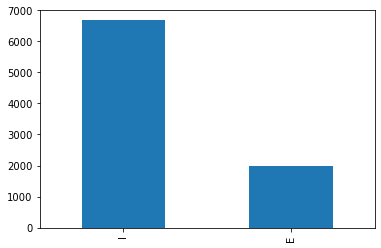

In [53]:
df_en['label_IE'].value_counts().plot(kind='bar') #Plot jumlah data berlabel introvert dan ekstrovert

<AxesSubplot:>

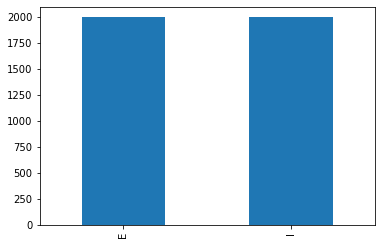

In [54]:
'''
Melakukan undersampling untuk kelas 'I'
'''

#Memisahkan data ekstrovert dan introvert (jumlah data introvert sebanyak jumlah ekstro)
extro = df_en[df_en['label_IE']=='E'] 
intro = df_en[df_en['label_IE']=='I'].sample(len(extro))

#Menggabungkan kedua data menjadi satu dan di-shuffle
new_df_eng = pd.concat([extro,intro]).sample(2*len(extro)).reset_index(drop=True)
new_df_eng['label_IE'].value_counts().plot(kind='bar')

In [55]:
from collections import Counter

#Menghitung frekuensi kemunculan tiap kata pada data dan dimasukkan ke variabel tmp
tmp = Counter(' '.join(new_df_eng['post_preproc']).split(' '))

In [56]:
#Membuat dataframe yang menyimpan informasi kata dan frekuensi kemunculannya
vocabs = pd.DataFrame({'word':tmp.keys(),'counts':tmp.values()})

In [59]:
#Menghitung jumlah kata maksimal dalam satu kalimat
max_len = new_df_eng['post_preproc'].str.split(' ').str.len().max()

In [62]:
#Memisahkan data train dan test dengan komposisi 80:20
train_dat,test_dat = train_test_split(new_df_eng,train_size=0.8)

'''
Menggunakan tf data input pipeline guna mengefisiensi training model deeplearning.
Shuffle(1024) -> ambil data random sebanyak 1024 data
cache() -> digunakan supaya pipeline dapat menggunakan data yang sudah dishuffle agar lebih efisien
batch(256) -> set maksimum 256 data dalam satu kloter
'''
train_dataset = tf.data.Dataset.from_tensor_slices((train_dat['post_preproc'], train_dat['label'])).shuffle(1024).cache().batch(64)
test_dataset = tf.data.Dataset.from_tensor_slices((test_dat['post_preproc'], test_dat['label'])).shuffle(1024).cache().batch(64)

In [63]:
'''
Mendefinisikan weight layer embedding untuk tiap kata menggunakan pre-trained weight dari Glove.
'''

path_to_glove_file = "glove.6B/glove.6B.50d.txt"

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

num_tokens = len(vocabs) + 2
embedding_dim = 50
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for i, word in enumerate(vocabs.word):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1

In [67]:
'''
Mendefinisikan layer vektorisasi teks yaitu proses mentransformasikan kata menjadi angka.
max_tokens=jml_vocab -> set jumlah maksimum token/kata
split="whitespace" -> pemisahan token/kata berdasarkan spasi
ngrams=None -> set pemisahan kata hanya berdasarkan tiap satu kata. 
    Misal "Saya ingin makan ikan":
    - ngrams=None -> "Saya","ingin","makan","ikan"
    - ngrams=2 -> "Saya ingin","makan ikan"
output_mode='int' -> set supaya output tokenisasi berupa bilangan bulat
output_sequence_length=max_sen_len -> set maksimal elemen satu kalimat sebanyak 50
input_shape=(1,) -> set ukuran data input berupa array 1D (vektor)
'''
text_vectorization = tf.keras.layers.TextVectorization(max_tokens=len(vocabs),
                                       split="whitespace",
                                       ngrams=None,
                                       output_mode="int",
                                       output_sequence_length=int(max_len),
                                       input_shape=(1,) # jika ingin menggunakan sequential API
                                       )

text_vectorization.adapt(train_dat['post_preproc']) #Training layer text vectorization berdasarkan data training

#Membuat arsitektur model
model = tf.keras.models.Sequential([text_vectorization,
                                    tf.keras.layers.Embedding(input_dim=num_tokens,
                                                            output_dim=embedding_dim,
                                                            input_length=int(max_len),
                                                            embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
                                                            trainable=False),
                                    tf.keras.layers.Dropout(0.3),
                                    tf.keras.layers.Conv1D(32,2,activation = 'relu'),
                                    tf.keras.layers.MaxPooling1D(),
                                    tf.keras.layers.Dropout(0.3),
                                    tf.keras.layers.Conv1D(16,2,activation = 'relu'),
                                    tf.keras.layers.MaxPooling1D(),
                                    tf.keras.layers.Flatten(),
                                    tf.keras.layers.Dropout(0.3),
                                    tf.keras.layers.Dense(8,activation='relu'),
                                    tf.keras.layers.Dropout(0.2),
                                    tf.keras.layers.Dense(1,activation='sigmoid')
])
#'''

model.summary()

2022-07-10 17:14:46.658537: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_8 (TextV  (None, 1892)             0         
 ectorization)                                                   
                                                                 
 embedding_8 (Embedding)     (None, 1892, 50)          5088150   
                                                                 
 dropout_32 (Dropout)        (None, 1892, 50)          0         
                                                                 
 conv1d_16 (Conv1D)          (None, 1891, 32)          3232      
                                                                 
 max_pooling1d_16 (MaxPoolin  (None, 945, 32)          0         
 g1D)                                                            
                                                                 
 dropout_33 (Dropout)        (None, 945, 32)          

In [68]:
epoch = 40 #Set jumlah epoch training

#Compile model, loss function, optimizer, dan metrik evaluasi
model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])
history_1 = model.fit(train_dataset, epochs=epoch, validation_data=test_dataset)

Epoch 1/40


2022-07-10 17:14:53.930652: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


50/50 [==============================] - ETA: 0s - loss: 0.6965 - accuracy: 0.5081

2022-07-10 17:14:58.064900: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


50/50 [==============================] - 5s 59ms/step - loss: 0.6965 - accuracy: 0.5081 - val_loss: 0.6934 - val_accuracy: 0.4625
Epoch 2/40
50/50 [==============================] - 3s 55ms/step - loss: 0.6931 - accuracy: 0.5094 - val_loss: 0.6936 - val_accuracy: 0.4625
Epoch 3/40
50/50 [==============================] - 2s 40ms/step - loss: 0.6933 - accuracy: 0.5094 - val_loss: 0.6937 - val_accuracy: 0.4625
Epoch 4/40
50/50 [==============================] - 2s 38ms/step - loss: 0.6901 - accuracy: 0.5094 - val_loss: 0.6936 - val_accuracy: 0.4625
Epoch 5/40
50/50 [==============================] - 2s 38ms/step - loss: 0.6932 - accuracy: 0.5094 - val_loss: 0.6937 - val_accuracy: 0.4625
Epoch 6/40
50/50 [==============================] - 2s 38ms/step - loss: 0.6919 - accuracy: 0.5094 - val_loss: 0.6939 - val_accuracy: 0.4625
Epoch 7/40
50/50 [==============================] - 2s 38ms/step - loss: 0.6898 - accuracy: 0.5094 - val_loss: 0.6943 - val_accuracy: 0.4625
Epoch 8/40
50/50 [======

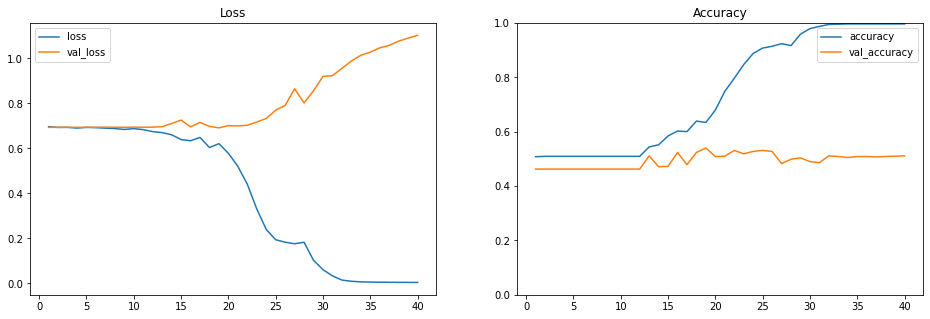

In [69]:
fig, ax = plt.subplots(ncols=2,figsize=(16,5))
ax[0].plot(range(1,epoch+1),history_1.history['loss'],label='loss')
ax[0].plot(range(1,epoch+1),history_1.history['val_loss'],label='val_loss')
ax[0].set_title('Loss')
ax[0].legend()
#ax[0].set_ylim(0,1)

ax[1].plot(range(1,epoch+1),history_1.history['accuracy'],label='accuracy')
ax[1].plot(range(1,epoch+1),history_1.history['val_accuracy'],label='val_accuracy')
ax[1].set_title('Accuracy')
ax[1].legend()
ax[1].set_ylim(0,1)

plt.show()

Model sangat overfit terutapa di setelah epoch 20

In [ ]:
model.save('model_english_1',save_format='tf')

INFO:tensorflow:Assets written to: model_english_1/assets


INFO:tensorflow:Assets written to: model_english_1/assets
